##s-CO2 Corrosion Severity Prediction##

Contains the code for the AMPP 2024 Conference and Expo paper "Predicting Corrosion Severity of Pipeline Steels in Supercritical CO2 Environments using Supervised Machine Learning"

**Data Set Characteristics**

In [1]:
# Description summmary or original data set
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()

Original_DS = pd.read_csv(io.BytesIO(uploaded['s-CO2-DS.csv']))

print(Original_DS.describe())

Saving s-CO2-DS.csv to s-CO2-DS.csv
           chrome        temp       press         H2O            O2  \
count  255.000000  255.000000  255.000000  255.000000    255.000000   
mean     0.088584   48.266667    9.256549   29.497224   5208.745105   
std      0.125709   20.371343    1.260215   62.878972  11634.587322   
min      0.000000   25.000000    8.000000    0.080000      0.000000   
25%      0.013000   40.000000    8.000000    0.963600      0.000000   
50%      0.040000   50.000000   10.000000    2.730000     20.000000   
75%      0.110000   50.000000   10.000000   34.000000   1000.000000   
max      0.540000  200.000000   18.200000  400.000000  47000.000000   

                SO2          NO2          H2S      rotate         time  \
count    255.000000   255.000000   255.000000  255.000000   255.000000   
mean    2034.764706    34.301961   122.745098    0.388235   191.009804   
std     5961.856609   127.005235   335.780196    0.488307   254.140300   
min        0.000000     0.00

**Upload Normalized Data Set**

In [2]:
# Import functions
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image
from google.colab import files

# Import data set
uploaded = files.upload()    # Used to upload data set csv

df = pd.read_csv(io.BytesIO(uploaded['s-CO2-DS-norm.csv']))

# Remove unnecessary features (Material, Refs)
X = df.drop(["material", "chrome", "rotate", "CR", "severity", "Refs."], axis=1)
y = df["severity"]

# Seperate into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

Saving s-CO2-DS-norm.csv to s-CO2-DS-norm.csv
         temp     press      H2O        O2    SO2   NO2  H2S      time
0    0.142857  0.196078  0.00105  0.000000  0.004  0.00  0.0  0.110228
1    0.142857  0.196078  0.00105  0.000000  0.000  0.20  0.0  0.110228
2    0.142857  0.196078  0.00105  0.000000  0.000  0.20  0.0  0.014896
3    0.142857  0.196078  0.00105  0.010638  0.000  0.00  0.0  0.110228
4    0.142857  0.196078  0.00105  0.000000  0.000  0.05  0.0  0.014896
..        ...       ...      ...       ...    ...   ...  ...       ...
250  0.200000  0.147059  0.00230  0.000000  1.000  0.00  0.5  1.000000
251  0.114286  0.196078  0.00221  0.638298  0.002  0.00  0.0  0.078451
252  0.114286  0.196078  0.00221  0.638298  0.002  0.00  0.0  0.157895
253  0.114286  0.196078  0.00221  0.638298  0.002  0.00  0.0  0.237339
254  0.114286  0.196078  0.00221  0.638298  0.002  0.00  0.0  0.316783

[255 rows x 8 columns]
0      1
1      1
2      3
3      1
4      2
      ..
250    4
251    3
252   

##Random Forest Model##

**Initial Model**

In [3]:
# Create and train RV model
RF_model = RandomForestClassifier(random_state=11)

RF_model.fit(X_train, y_train)

# Test model against training and test set
RF_pred_train = RF_model.predict(X_train)
RF_pred_test = RF_model.predict(X_test)

# Errors for the training and testing of model to check for overfitting
MSE_train = mean_squared_error(y_train, RF_pred_train)
r2_train = r2_score(y_train, RF_pred_train)
print('MSE train = ', MSE_train)
print("R-squared score for training is ", r2_train)

MSE_test = mean_squared_error(y_test, RF_pred_test)
r2_test = r2_score(y_test, RF_pred_test)
print('MSE test = ', MSE_test)
print("R-squared score for testing is ", r2_test)


MSE train =  0.06862745098039216
R-squared score for training is  0.9485924112607099
MSE test =  0.47058823529411764
R-squared score for testing is  0.6838842975206613


**Hyperparameter Optimization**

In [4]:
# Hyperparameter optimization
RF_param = {'max_depth': [5,6,7,8,9,10,20,30,40,50],
            'n_estimators': [5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}

RF_model_tuned = GridSearchCV(RandomForestClassifier(random_state=11), RF_param, verbose = 1, cv=3, n_jobs = -1)

RF_model_tuned.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters: ', RF_model_tuned.best_estimator_)

# Test optimized model with the training and test set
RF_Best_Train = RF_model_tuned.predict(X_train)
RF_Best_test = RF_model_tuned.predict(X_test)

MSE_best_train = mean_squared_error(y_train, RF_Best_Train)
r2_best_train = r2_score(y_train, RF_Best_Train)
print('Training Results:')
print('Best MSE = ', MSE_best_train)
print("R-squared score for best model is ", r2_best_train)

MSE_best_test = mean_squared_error(y_test, RF_Best_test)
r2_best_test = r2_score(y_test, RF_Best_test)
print('Test Results: ')
print('Best MSE = ', MSE_best_test)
print("R-squared score for best model is ", r2_best_test)

RF_accurate = accuracy_score(y_test, RF_Best_test)
print('Model accuracy: ', RF_accurate)

print(X_test, y_test, RF_Best_test)

Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best hyperparameters:  RandomForestClassifier(max_depth=9, n_estimators=30, random_state=11)
Training Results:
Best MSE =  0.08823529411764706
R-squared score for best model is  0.93390452876377
Test Results: 
Best MSE =  0.45098039215686275
R-squared score for best model is  0.697055785123967
Model accuracy:  0.7058823529411765
         temp     press       H2O        O2      SO2    NO2   H2S      time
137  0.142857  0.196078  0.001700  0.021277  0.40000  0.000  0.00  0.078451
144  0.142857  0.196078  0.003201  0.023404  0.40000  0.000  0.00  0.014896
26   0.000000  0.196078  0.001025  0.000000  0.00000  0.191  0.00  0.316783
174  0.114286  0.098039  0.227120  0.664894  0.00000  0.000  0.00  0.330023
198  0.057143  0.000000  0.227118  0.000000  0.00000  0.000  0.00  0.078451
170  0.114286  0.047059  0.227120  0.000000  0.00000  0.000  0.00  0.330023
217  0.114286  0.196078  0.227118  0.000000  0.00000  0.000  0.00  0.07845

**K-Fold Cross Validation**

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Create pipeline
Pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=30, n_estimators=15, random_state=11))

# Pass model through pipeline and training and test data set
scores = cross_val_score(Pipeline, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Cross Validation accuracy scores: %s' % scores)

print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.61904762 0.66666667 0.61904762 0.71428571 0.9        0.75
 0.8        0.65       0.75       0.65      ]
Cross Validation accuracy: 0.712 +/- 0.085


**Model Visualization and Feature Importance**

[0.06848166 0.07300413 0.23228552 0.13971143 0.2173605  0.06452767
 0.06927313 0.13535596]


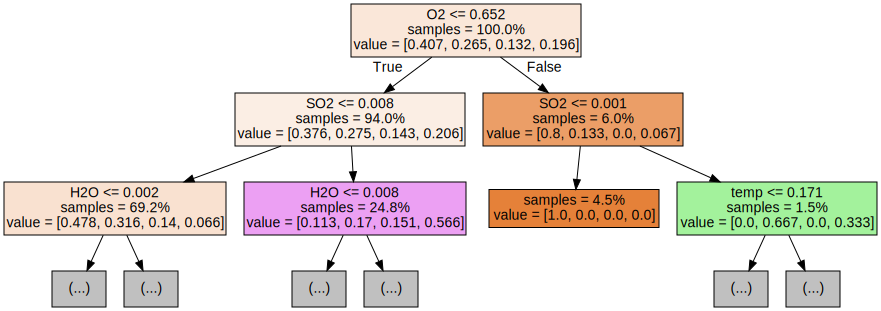

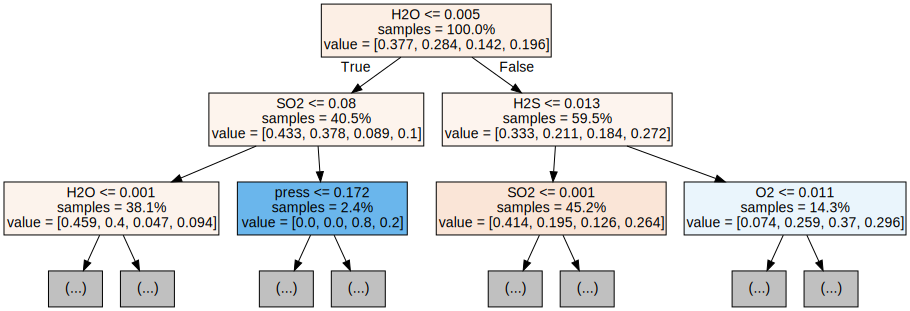

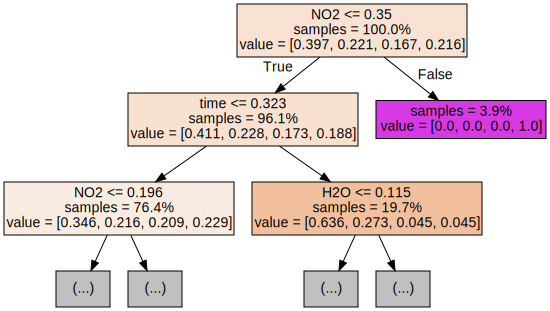

In [6]:
#Create and refit best fit model
RF = RandomForestClassifier(max_depth=30, n_estimators=15, random_state=11)

RF.fit(X_train, y_train)

#Feature importance
print(RF.feature_importances_)

#Visualize first 3 tress in the forest
from sklearn.tree import export_graphviz
import graphviz

for i in range(3):
    tree = RF.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

##K-Nearest Neighbors Model##

**Initial Model Creation**

In [7]:
# Create and train KNN model
KNN_model = KNeighborsClassifier()

KNN_model.fit(X_train, y_train)

# Test model against trainind and test set
KNN_pred_train = KNN_model.predict(X_train)
KNN_pred_test = KNN_model.predict(X_test)

#Errors for training and testing of model to check for overfitting
MSE_train = mean_squared_error(y_train, KNN_pred_train)
r2_train = r2_score(y_train, KNN_pred_train)
print('MSE train = ', MSE_train)
print("R-squared score for training is ", r2_train)

MSE_test = mean_squared_error(y_test, KNN_pred_test)
r2_test = r2_score(y_test, KNN_pred_test)
print('MSE test = ', MSE_test)
print("R-squared score for testing is ", r2_test)

MSE train =  0.8480392156862745
R-squared score for training is  0.364749082007344
MSE test =  1.0784313725490196
R-squared score for testing is  0.2755681818181821


**Hyperparameter Optimization**

In [8]:
# Create parameter ranges
KNN_param = {'n_neighbors' : [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
             'weights' : ['uniform', 'distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'metric' : ['minkowski','euclidean','manhattan']
             }

# Tune KNN algorithim to find best
KNN_opt = GridSearchCV(KNeighborsClassifier(), KNN_param, verbose = 1, cv=3, n_jobs = -1)

# Tune best fit model
KNN_best = KNN_opt.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters: ', KNN_opt.best_estimator_)

# Test model against training and test set
KNN_best_train = KNN_best.predict(X_train)
KNN_best_test = KNN_best.predict(X_test)

# Errors for training and testing of model to check for overfitting
KNN_best_MSE_train = mean_squared_error(y_train, KNN_best_train)
KNN_best_r2_train = r2_score(y_train, KNN_best_train)
print('MSE train = ', KNN_best_MSE_train)
print("R-squared score for training is ", KNN_best_r2_train)

KNN_best_MSE_test = mean_squared_error(y_test, KNN_best_test)
KNN_best_r2_test = r2_score(y_test, KNN_best_test)
print('MSE test = ', KNN_best_MSE_test)
print('R-squared score for test is ', KNN_best_r2_test)

KNN_accurate = accuracy_score(y_test, KNN_best_test)
print('Model accuracy: ', KNN_accurate)

print(X_test, y_test, KNN_best_test)

Fitting 3 folds for each of 552 candidates, totalling 1656 fits
Best hyperparameters:  KNeighborsClassifier(n_neighbors=3, weights='distance')
MSE train =  0.06862745098039216
R-squared score for training is  0.9485924112607099
MSE test =  0.9215686274509803
R-squared score for test is  0.3809400826446283
Model accuracy:  0.6078431372549019
         temp     press       H2O        O2      SO2    NO2   H2S      time
137  0.142857  0.196078  0.001700  0.021277  0.40000  0.000  0.00  0.078451
144  0.142857  0.196078  0.003201  0.023404  0.40000  0.000  0.00  0.014896
26   0.000000  0.196078  0.001025  0.000000  0.00000  0.191  0.00  0.316783
174  0.114286  0.098039  0.227120  0.664894  0.00000  0.000  0.00  0.330023
198  0.057143  0.000000  0.227118  0.000000  0.00000  0.000  0.00  0.078451
170  0.114286  0.047059  0.227120  0.000000  0.00000  0.000  0.00  0.330023
217  0.114286  0.196078  0.227118  0.000000  0.00000  0.000  0.00  0.078451
135  0.142857  0.196078  0.000000  0.021277  0.40

**K-Fold Cross Validation**

In [9]:
# Create pipeline
Pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3, weights='distance'))

# Pass model through pipeline and training and test data set
scores = cross_val_score(Pipeline, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Cross Validation accuracy scores: %s' % scores)

print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.52380952 0.61904762 0.61904762 0.61904762 0.65       0.6
 0.65       0.65       0.55       0.7       ]
Cross Validation accuracy: 0.618 +/- 0.049


##Support Vector Machine Model##

**Inital Model**

In [10]:
# Create model
SVM_Model = SVC()

SVM_Model.fit(X_train, y_train)

# Test model against test set
SVM_y_pred = SVM_Model.predict(X_test)
SVM_y_train = SVM_Model.predict(X_train)

# Errors for training and testing of model to check for overfitting
SVM_MSE_train = mean_squared_error(y_train, SVM_y_train)
SVM_r2_train = r2_score(y_train, SVM_y_train)
print('MSE train = ', SVM_MSE_train)
print("R-squared score for training is ", SVM_r2_train)

SVM_MSE_test = mean_squared_error(y_test, SVM_y_pred)
SVM_r2_test = r2_score(y_test, SVM_y_pred)
print('MSE test = ', SVM_MSE_test)
print("R-squared score for testing is ", SVM_r2_test)

MSE train =  1.5147058823529411
R-squared score for training is  -0.13463892288861667
MSE test =  1.5490196078431373
R-squared score for testing is  -0.04054752066115652


**Hyperparameter Optimization**

In [11]:
# Create hyperparameter range
SVM_param = { 'C' : [0.1, 1, 10, 100, 1000, 10000],
             'gamma' : [1.1, 1, 0.1, 0.01, 0.001, 0.0001]}

# Find best hyperparameters
SVM_opt = GridSearchCV(SVC(), SVM_param, verbose = 1, cv = 3, n_jobs = -1)

# Fit best model
SVM_best = SVM_opt.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters: ', SVM_best.best_estimator_)

# Test model against test set
SVM_best_y_pred = SVM_best.predict(X_test)
SVM_best_y_train = SVM_best.predict(X_train)

# Errors for training and testing of model to check for overfitting
SVM_best_MSE_train = mean_squared_error(y_train, SVM_best_y_train)
SVM_best_r2_train = r2_score(y_train, SVM_best_y_train)
print('MSE train = ', SVM_best_MSE_train)
print("R-squared score for training is ", SVM_best_r2_train)

SVM_best_MSE_test = mean_squared_error(y_test, SVM_best_y_pred)
SVM_best_r2_test = r2_score(y_test, SVM_best_y_pred)
print('MSE test = ', SVM_best_MSE_test)
print("R-squared score for testing is ", SVM_best_r2_test)

SVM_accurate = accuracy_score(y_test, SVM_best_y_pred)
print('Model accuracy: ', SVM_accurate)

print(X_test, y_test, SVM_best_y_pred)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best hyperparameters:  SVC(C=1000, gamma=1)
MSE train =  0.7205882352941176
R-squared score for training is  0.46022031823745413
MSE test =  1.4509803921568627
R-squared score for testing is  0.025309917355372247
Model accuracy:  0.6078431372549019
         temp     press       H2O        O2      SO2    NO2   H2S      time
137  0.142857  0.196078  0.001700  0.021277  0.40000  0.000  0.00  0.078451
144  0.142857  0.196078  0.003201  0.023404  0.40000  0.000  0.00  0.014896
26   0.000000  0.196078  0.001025  0.000000  0.00000  0.191  0.00  0.316783
174  0.114286  0.098039  0.227120  0.664894  0.00000  0.000  0.00  0.330023
198  0.057143  0.000000  0.227118  0.000000  0.00000  0.000  0.00  0.078451
170  0.114286  0.047059  0.227120  0.000000  0.00000  0.000  0.00  0.330023
217  0.114286  0.196078  0.227118  0.000000  0.00000  0.000  0.00  0.078451
135  0.142857  0.196078  0.000000  0.021277  0.40000  0.000  0.00  0.078451
214  

**K-Fold Cross Validation**

In [12]:
# Create pipeline
Pipeline = make_pipeline(StandardScaler(), SVC(C=1000, gamma=1))

# Pass model through pipeline and training and test data set
scores = cross_val_score(Pipeline, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Cross Validation accuracy scores: %s' % scores)

print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.38095238 0.61904762 0.52380952 0.42857143 0.65       0.75
 0.7        0.65       0.65       0.6       ]
Cross Validation accuracy: 0.595 +/- 0.111
